In [129]:
import gmaps
import gmaps.heatmap

import os
import random
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv, find_dotenv
import requests

### Retrieve Google API Key

In [74]:
load_dotenv(find_dotenv())
API_KEY = os.getenv("API_KEY")
gmaps.configure(api_key=API_KEY)

### Utility Functions

The following section provies utility functions to:

* `get_boundaries` Get latitude, longitude boundaries given a centre coordinate and a radius
* `get_grid_points` Get evenly spaced coodinates given lat, lon boundaries and granularity (offset in meters)
* `generate_points` Randomly generate coordinate locations given the boundaries
* `generate_weights` Randomly generate weights for each coordinate location
* `create_heatmap` Render a heatmap given centre, safe places, location hotspots, weights, and max intensity

In [82]:
def get_boundaries(centre, radius=2):
    """
    Given a centre coordinate and specified radius (in km)
    generate a bounding box of lat, lon
    """
    R_EARTH = 6_378
    lat, lon = centre
    
    lat_high = lat  + (radius / R_EARTH) * (180 / math.pi)
    lat_low = lat - (radius / R_EARTH) * (180 / math.pi)
    
    lon_high = lon + (radius / R_EARTH ) * (180 / math.pi) / math.cos(lat * math.pi/180)
    lon_low = lon - (radius / R_EARTH ) * (180 / math.pi) / math.cos(lat * math.pi/180)
    
    return ((lat_low, lat_high), (lon_low, lon_high))

In [83]:
def get_grid_points(boundaries, granularity=20):
    """
    Retrieve an lat, lon coordinates given boundaries and granularity (in meters)
    """
    R_EARTH = 6_378
    
    lat_bound, lon_bound = boundaries
    
    lat_diff = ((granularity / 1000) / R_EARTH) * (180 / math.pi)
        
    start_lat, end_lat = lat_bound
    lat_points = [start_lat]
    while end_lat > start_lat:
        start_lat += lat_diff
        lat_points.append(start_lat)
        
    def get_lon_diff(lat_):
        return ((granularity / 1000) / R_EARTH) * (180 / math.pi) / cos(lat_ * pi/180)
    
    lon_diffs = [get_lon_diff(i) for i in lat_points]
    
    start_lon, end_lon = lon_bound
    lon_points = [start_lon]
    lon_diffs_num = 0
    while end_lon > start_lon:
        start_lon += lon_diffs[lon_diffs_num]
        lon_points.append(start_lon)
        lon_diffs_num += 1
        
    return list(zip(lat_points, lon_points))

In [84]:
def generate_points(boundaries, num_points):
    """
    Randomly generate points given boundaries
    """
    lat_bound, lon_bound = boundaries
        
    return [(random.uniform(*lat_bound), random.uniform(*lon_bound))
            for i in range(num_points)]

In [85]:
def generate_weights(num_points):
    """
    Randomly generate weights
    """
    return [random.random() for i in range(num_points)]

In [366]:
def get_places(location, radius, typ, keyword, open_now=True):
    """
    Retrieve from Google Maps Directions API, nearest location based on type and keyword
    """
    lat, lon = location
    
    req_url = ('https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={},{}&radius={}&type={}&keyword={}&opennow={}&key={}'
               .format(lat, lon, radius, typ, keyword, open_now, API_KEY))
    
    response_dict = requests.get(req_url).json()

    nearby_places = [{'name': entry['name'], 'coordinates': entry['geometry']['location']}
                     for entry in response_dict['results'][:10]]
    
    return nearby_places

In [351]:
def create_heatmap(centre, places, locations, weights, max_weight):
    """
    Render heatmap of hotspots with directions to safespots
    """
    fig = gmaps.figure()
    heatmap = gmaps.heatmap_layer(locations, weights)
    symbol_layer = gmaps.symbol_layer(locations)
    places_symbol_layer = gmaps.symbol_layer(places)
    
    symbol_layer.markers = [gmaps.Symbol(location=centre, fill_color='red')]
    places_symbol_layer.markers = [gmaps.Symbol(location=place, fill_color='blue') for place in places]
    
    heatmap.max_intensity = max_weight
    heatmap.point_radius = 25
    
    fig.add_layer(heatmap)
    fig.add_layer(symbol_layer)
    fig.add_layer(places_symbol_layer)
    
    stroke_colors = ['aqua', 'olive', 'yellow', 'lime', 'red', 'black', 'green', 'blue', 'gray', 'fuschia']
    directions = [gmaps.directions_layer(centre,
                                         place, 
                                         stroke_color=stroke_colors[color_idx],
                                         stroke_opacity=0.5,
                                         travel_mode='WALKING')
                  for color_idx, place in enumerate(places)]
    
    for direction in directions:
        fig.add_layer(direction)
    
    return fig

### Sample Run

The following illustrates a trial run:
* Define the centre as `19.069, 72.8777`, the actual centre of Mumbai
* Define a radius of `2 km` around the centre
* Randomly generate 200 coordinates and weights
* Retrieve closest hospitals (safe spot) within a defined radius
* Show directions to each hospital alongside the danger spots on Google Maps

In [367]:
centre = (19.069, 72.8777) # centre of Mumbai
boundaries = get_boundaries(centre=centre)
locations = generate_points(boundaries, 200)
weights = generate_weights(200)

places = get_places(centre, 1000, 'hospital', 'hospital')
places = [(i['coordinates']['lat'], i['coordinates']['lng']) for i in places]
create_heatmap(centre, places, locations, weights, 4)

Figure(layout=FigureLayout(height='420px'))

### Mapping Hotspots and Safespots from matrix

The following section details mapping to a sample matrix of Mumbai from `Task 1` with danger levels generated to Google Maps

In [90]:
# define boundaries for Mumbai
D_MIN_LAT = 28.490665
D_MAX_LAT = 28.75683

D_MIN_LON = 77.017121
D_MAX_LON = 77.339847

In [122]:
def create_grid(file_name):
    """
    Read in grid and flatten into 1D array
    """
    grid = []
    with open(file_name) as f:
        for line in f.readlines():
            grid.append(line.rstrip('\n'))
            
    grid = np.array([row.split(',') for row in grid])
    
    return grid.astype(float)

In [111]:
def get_coordinates(lat_min, lat_max, lon_min, lon_max, dimension):
    """
    Get coordinates based on min, max boundaries and resolution (dimension)
    Note: coordinates are not generated according to distance metric, as
    they are evenly spaced lat, lon values based on dimension
    """
    lat_diff = (lat_max - lat_min) / (dimension - 1)
    lon_diff = (lon_max - lon_min) / (dimension - 1)
    
    lat_values = [lat_min + lat_diff * i for i in range(dimension)]
    lon_values = [lon_min + lon_diff * i for i in range(dimension)]
    
    coordinates = [[(j, i) for i in lon_values] for j in lat_values][::-1]
    
    return [j for i in coordinates for j in i]

In [112]:
def rescale(weights):
    """
    Rescale weights to [0, 1] if needed
    """
    return [(i - min(weights)) / (max(weights) - min(weights)) for i in weights]

### Trial run of Heatmapping

Here we test generating a heatmap on Mumbai and check the nearest hospitals to `28.65825037037037, 77.2561772962963` within `2 km`.

In [368]:
locations = get_coordinates(D_MIN_LAT, D_MAX_LAT, D_MIN_LON, D_MAX_LON, 28)
weights = create_grid('sample_grid.csv').flatten()
places = get_places(locations[300], 2000, 'hospital', 'hospital')
places = [(i['coordinates']['lat'], i['coordinates']['lng']) for i in places]
create_heatmap(locations[300], places, locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

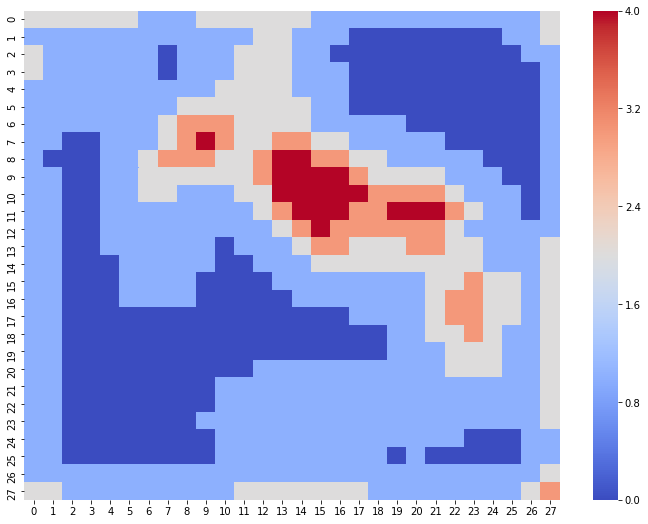

In [145]:
# validate heatmap looks correct using viz library
plt.figure(figsize=(12, 9))
sns.heatmap(create_grid('sample_grid.csv'), cmap='coolwarm')

### Calculation of Safest Route

The following sections details ways to recommend the safest route to a safespot given a lat, lon coordinate.

Below are the various proposed methods:

* **Method 1**: Safest route is determined by safest destination, whichever destination is closest to a coordinate that is the least dangerous

* **Method 2**: Calculation based on weighted average of danger on the 'legs' of routes generated by `Directions API`; each leg has a starting and ending coordinate

* **Method 3**: Calculation based on `line of sight` algorithm; create line segments for each leg of the a route and find the gridboxes that each leg segment passes through

#### Method 1: Safest Destination

In [370]:
sample_places = get_places(locations[300], 2000, 'hospital', 'hospital')
sample_places

[{'name': 'Khadija National Hospital',
  'coordinates': {'lat': 28.6438065, 'lng': 77.2381575}},
 {'name': 'Sabharwal Hospital',
  'coordinates': {'lat': 28.6443783, 'lng': 77.2386641}},
 {'name': 'Jain Charitable Hospital',
  'coordinates': {'lat': 28.6649861, 'lng': 77.2699534}},
 {'name': 'Dehli Hospital',
  'coordinates': {'lat': 28.6417933, 'lng': 77.2450101}},
 {'name': 'Jag Pravesh Chandra Hospital',
  'coordinates': {'lat': 28.6762461, 'lng': 77.2629156}},
 {'name': 'Vyas Charitable Hospital',
  'coordinates': {'lat': 28.660889, 'lng': 77.268093}},
 {'name': 'Govind Ballabh Pant Hospital',
  'coordinates': {'lat': 28.6393553, 'lng': 77.23503319999999}},
 {'name': 'Lok Nayak Hospital',
  'coordinates': {'lat': 28.6390815, 'lng': 77.2376888}},
 {'name': 'RS Grover Hospital',
  'coordinates': {'lat': 28.6426051, 'lng': 77.2774488}},
 {'name': 'Government Hospital',
  'coordinates': {'lat': 28.668388, 'lng': 77.2774766}}]

In [369]:
create_heatmap(locations[300], [(place['coordinates']['lat'], place['coordinates']['lng']) for place in sample_places], locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

In [371]:
def calc_distance(a, b):
    return math.sqrt(abs(a[0] - b[0])**2 + abs(a[1] - b[1])**2)

In [487]:
def find_nearest(coordinates, locations):
    """
    Find nearest point given safespot coordinates
    """
    lat, lon = coordinates
    distances = [calc_distance((lat, lon), i) for i in locations]
    
    return np.where(np.array(distances) == np.amin(distances))[0][0]

In [488]:
find_nearest(locations[300], locations)

300

In [254]:
%timeit find_nearest(locations[300], locations)

1.11 ms ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [409]:
def find_best_spot(starting_point, places, danger_weights, locations):
    """
    Given a starting point and list of safe spots and their respective danger weights,
    find the best spot to go
    """
    # calc and update distances
    [place.update({'distance': calc_distance(starting_point,
                                             (place['coordinates']['lat'],
                                              place['coordinates']['lng']))}) for place in places]
    
    # calc weights
    [place.update({'danger_score': danger_weights[
        find_nearest(
            (place['coordinates']['lat'],
             place['coordinates']['lng']), locations)]}) for place in places]
                                                           

    return sorted(places, key=lambda x: (x['danger_score'], x['distance']))[0]

In [257]:
# time to see how efficient
%timeit find_best_spot(sample_places, weights, locations)

10.4 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [410]:
# best spot based on the 300th starting point
best_spot = find_best_spot(locations[300], sample_places, weights, locations)

In [411]:
best_spot

{'name': 'Jag Pravesh Chandra Hospital',
 'coordinates': {'lat': 28.6762461, 'lng': 77.2629156},
 'distance': 0.01921590543549743,
 'danger_score': 1.0}

In [413]:
# get the best coordinates
best_coordinates = best_spot['coordinates']['lat'], best_spot['coordinates']['lng']

In [415]:
create_heatmap(locations[300], [best_coordinates], locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

In [444]:
# another example
sample_places = get_places(locations[350], 2000, 'hospital', 'hospital')
sample_places_c = [(i['coordinates']['lat'], i['coordinates']['lng']) for i in sample_places]
create_heatmap(locations[350], sample_places_c, locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

In [446]:
# in this case, the best route is the one furthest from the danger spots
best_spot = find_best_spot(locations[350], sample_places, weights, locations)
best_coordinates = best_spot['coordinates']['lat'], best_spot['coordinates']['lng']
create_heatmap(locations[350], [best_coordinates], locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

#### Method 2: Safest Route based on Weighted `Steps`

In [537]:
def get_route(starting_point, dest_point):
    """
    Get the ending lat, lon steps for each route given starting and destination coordinates
    """
    
    request_url = ('https://maps.googleapis.com/maps/api/directions/'
    + 'json?origin={}&destination={}&mode=walking&key={}').format(','.join(map(str,starting_point)),
                                                                   ','.join(map(str,dest_point)),
                                                                   API_KEY)
    
    response = requests.get(request_url).json()['routes'][0]['legs'][0]

    return_dct = {'total_distance': response['distance']['value']}
    
    return_dct.update({'steps': [{'end': step['end_location']} for step in response['steps']]})
    
    return return_dct

In [583]:
def compute_weighted_danger(routes, locations):
    """
    Compute danger for each ending lat, lon coordinate for each route
    """
    steps = [(step['end']['lat'], step['end']['lng']) for step in routes['steps']]
    nearest_coordinates = [find_nearest(step, locations) for step in steps]
    
    return np.mean([weights[idx] for idx in nearest_coordinates])

In [582]:
def sort_routes(routes):
    """
    Return routes list sorted first by danger, then by distance
    """
    [route.update({'danger' : compute_weighted_danger(route, locations)}) for route in routes]
    return sorted(routes, key = lambda x: (x['danger'], x['total_distance']))

In [584]:
places = get_places(locations[350], 2000, 'hospital', 'hospital')
places = [(i['coordinates']['lat'], i['coordinates']['lng']) for i in places]
routes = [get_route(locations[350], place) for place in places]

In [585]:
# same example based on location #350 for nearest hospitals
sample_places = get_places(locations[350], 2000, 'hospital', 'hospital')
sample_places_c = [(i['coordinates']['lat'], i['coordinates']['lng']) for i in sample_places]
create_heatmap(locations[350], sample_places_c, locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))

In [586]:
# retrieve the top ranked best route
best_route = sort_routes(routes)[0]

# get coordinates of last ending point
best_coordinates = (best_route['steps'][-1]['end']['lat'], best_route['steps'][-1]['end']['lng'])

# show directions on heatmap of best route
create_heatmap(locations[350], [best_coordinates], locations, weights, max(weights))

Figure(layout=FigureLayout(height='420px'))